In [103]:
# !pip install fuzzywuzzy python-Levenshtein geopandas pandas numpy matplotlib

In [104]:
# =============================================================================
# DATA LOADING AND PREPROCESSING
# This cell handles the initial loading and preparation of the hurricane tweet data.
# Key steps include:
# 1. Importing necessary libraries for data manipulation, file paths, and time handling.
# 2. Constructing file paths to the GeoJSON data for Hurricanes Francine and Helene.
# 3. Loading the spatial data into GeoDataFrames.
# 4. Standardizing all timestamps to Coordinated Universal Time (UTC).
# 5. Aggregating the data into discrete 4-hour time bins for temporal analysis.
# 6. Creating various time-related columns (Unix timestamps, readable labels) for later use.
# =============================================================================

# Import core libraries
import geopandas as gpd  # Used for working with geospatial data.
import pandas as pd      # Used for data manipulation and analysis in DataFrames.
import os                # Provides a way of using operating system dependent functionality, like file paths.
from datetime import datetime, timezone # Used for handling date and time objects.

# --- 1. Load GeoJSON files ---
# Get the parent directory of the current working directory to build relative paths.
# This makes the script more portable as it doesn't rely on a hardcoded absolute path.
local_path = os.path.dirname(os.getcwd())

# Define the relative paths to the GeoJSON files for each hurricane.
francine_dir = r"\data\geojson\francine.geojson"
helene_dir = r"\data\geojson\helene.geojson"

# Combine the base path and relative directory to create full, absolute paths to the files.
francine_path = f"{local_path}{francine_dir}"
helene_path = f"{local_path}{helene_dir}"

# --- 2. Load data into GeoDataFrames ---
# A GeoDataFrame is a pandas DataFrame with a special 'geometry' column that allows for spatial operations.
francine_gdf = gpd.read_file(francine_path)
helene_gdf = gpd.read_file(helene_path)

# --- 3. Standardize timestamps to UTC ---
# Convert the original 'time' column into a pandas datetime object.
# Setting `utc=True` ensures all timestamps are in a single, unambiguous timezone (UTC).
# This is crucial for accurate temporal comparisons and binning.
francine_gdf['timestamp'] = pd.to_datetime(francine_gdf['time'], utc=True)
helene_gdf['timestamp'] = pd.to_datetime(helene_gdf['time'], utc=True)

# --- 4. Group data into 4-hour time bins ---
# The `dt.floor('4h')` function rounds each timestamp *down* to the nearest 4-hour interval.
# For example, 09:35 becomes 08:00, 15:59 becomes 12:00. This aggregates tweets into discrete time windows.
francine_gdf['time_bin'] = francine_gdf['timestamp'].dt.floor('4h')
helene_gdf['time_bin'] = helene_gdf['timestamp'].dt.floor('4h')

# --- 5. Create Unix timestamps and lookup dictionaries ---
# Convert the binned datetime objects into Unix timestamps (as an integer).
# The `// 1000` division is likely to convert from nanoseconds or microseconds to seconds, a more standard Unix format.
francine_gdf['unix_timestamp'] = francine_gdf['time_bin'].astype('int64') // 1000
helene_gdf['unix_timestamp'] = helene_gdf['time_bin'].astype('int64') // 1000

# Create dictionaries to map the numeric Unix timestamp back to its original datetime object.
# This provides a quick way to retrieve the readable time bin later in the script without recalculating it.
helene_timestamp_dict = dict(zip(helene_gdf['unix_timestamp'], helene_gdf['time_bin']))
francine_timestamp_dict = dict(zip(francine_gdf['unix_timestamp'], francine_gdf['time_bin']))

# --- 6. Create readable labels for file naming ---
# The `dt.strftime` function formats the datetime object into a specific string format.
# Here, '%Y%m%d_%H%M' creates a clean, sortable label like '20240926_0800', which is ideal for filenames.
francine_gdf['bin_label'] = francine_gdf['time_bin'].dt.strftime('%Y%m%d_%H%M')
helene_gdf['bin_label'] = helene_gdf['time_bin'].dt.strftime('%Y%m%d_%H%M')

In [105]:
# Load reference shapefiles
from fuzzywuzzy import fuzz, process
import re

states_dir = r"\data\shape_files\cb_2023_us_state_20m.shp"
counties_dir = r"\data\shape_files\cb_2023_us_county_20m.shp"
cities_dir = r"\data\shape_files\US_Cities.shp"
states_path = f"{local_path}{states_dir}"
counties_path = f"{local_path}{counties_dir}"
cities_path = f"{local_path}{cities_dir}"


# Load spatial reference data
states_gdf = gpd.read_file(states_path)
counties_gdf = gpd.read_file(counties_path)
cities_gdf = gpd.read_file(cities_path)

# PLACE THIS CODE AFTER LOADING SHAPEFILES BUT BEFORE CREATING SIMPLE LOOKUPS
# =============================================================================
# MULTI-LEVEL GEOGRAPHIC MATCHING SYSTEM (ALL LEVELS)
# =============================================================================

from fuzzywuzzy import fuzz, process
import re

def preprocess_place_name(name):
    """Standardize place names for better matching"""
    if pd.isna(name) or name == 'NAN':
        return None

    name = str(name).upper().strip()

    # Common abbreviation standardizations
    name = re.sub(r'\bST\.?\b', 'SAINT', name)  # St. -> Saint
    name = re.sub(r'\bMT\.?\b', 'MOUNT', name)  # Mt. -> Mount
    name = re.sub(r'\bFT\.?\b', 'FORT', name)   # Ft. -> Fort
    name = re.sub(r'\bN\.?\b', 'NORTH', name)   # N. -> North
    name = re.sub(r'\bS\.?\b', 'SOUTH', name)   # S. -> South
    name = re.sub(r'\bE\.?\b', 'EAST', name)    # E. -> East
    name = re.sub(r'\bW\.?\b', 'WEST', name)    # W. -> West

    # Remove extra spaces and punctuation
    name = re.sub(r'[^\w\s]', '', name)  # Remove punctuation
    name = re.sub(r'\s+', ' ', name)     # Normalize spaces

    return name.strip()

def parse_gpe_entities(gpe_string):
    """Parse GPE string into multiple potential geographic entities"""
    if not gpe_string or pd.isna(gpe_string) or str(gpe_string).strip() == '':
        return []

    gpe_string = str(gpe_string).strip()

    # Split by common separators
    entities = []

    # Primary split by comma
    parts = [part.strip() for part in gpe_string.split(',')]

    for part in parts:
        if part:
            # Further split by other separators
            sub_parts = re.split(r'[;&|]', part)
            for sub_part in sub_parts:
                sub_part = sub_part.strip()
                if sub_part and len(sub_part) > 1:  # Ignore single characters
                    entities.append(preprocess_place_name(sub_part))

    # Remove None values and duplicates while preserving order
    clean_entities = []
    seen = set()
    for entity in entities:
        if entity and entity not in seen:
            clean_entities.append(entity)
            seen.add(entity)

    return clean_entities

def create_hierarchical_lookups(states_gdf, counties_gdf, cities_gdf):
    """Create hierarchical lookup dictionaries for fuzzy matching"""
    print("\nCreating hierarchical lookup dictionaries...")

    # 1. States - simple lookup with preprocessed names + abbreviations
    state_lookup = {}
    state_abbrev_to_name = {}  # Abbreviation to full name
    state_name_to_abbrev = {}  # Full name to abbreviation

    for idx, row in states_gdf.iterrows():
        state_name = preprocess_place_name(row['NAME'])
        if state_name:
            state_lookup[state_name] = row.geometry
            # Handle abbreviations if available
            if 'STUSPS' in row:
                abbrev = row['STUSPS'].upper()
                state_abbrev_to_name[abbrev] = state_name
                state_name_to_abbrev[state_name] = abbrev
                # Also add abbreviation as a lookup option
                state_lookup[abbrev] = row.geometry

    # 2. Counties - organized by state
    county_by_state = {}
    county_lookup = {}

    for idx, row in counties_gdf.iterrows():
        county_name = preprocess_place_name(row['NAME'])
        state_fips = row.get('STATEFP', '')

        if county_name:
            county_lookup[county_name] = row.geometry

            # Try to get state name from STATEFP or other fields
            state_name = None
            if 'STATE_NAME' in row:
                state_name = preprocess_place_name(row['STATE_NAME'])
            else:
                # Try to find state by FIPS code
                for s_idx, s_row in states_gdf.iterrows():
                    if s_row.get('STATEFP', '') == state_fips:
                        state_name = preprocess_place_name(s_row['NAME'])
                        break

            if state_name:
                if state_name not in county_by_state:
                    county_by_state[state_name] = {}
                county_by_state[state_name][county_name] = row.geometry

    # 3. Cities - organized by state
    city_by_state = {}
    city_lookup = {}

    for idx, row in cities_gdf.iterrows():
        city_name = preprocess_place_name(row['NAME'])
        state_abbrev = row.get('ST', '').upper()

        if city_name:
            city_lookup[city_name] = row.geometry

            # Convert state abbreviation to full name
            if state_abbrev in state_abbrev_to_name:
                state_full = state_abbrev_to_name[state_abbrev]
                if state_full not in city_by_state:
                    city_by_state[state_full] = {}
                city_by_state[state_full][city_name] = row.geometry
    #


    return {
        'state_lookup': state_lookup,
        'county_lookup': county_lookup,
        'city_lookup': city_lookup,
        'county_by_state': county_by_state,
        'city_by_state': city_by_state,
        'state_abbrev_to_name': state_abbrev_to_name,
        'state_name_to_abbrev': state_name_to_abbrev
    }

def fuzzy_match_entity(entity, candidates, threshold=75):
    """Fuzzy match an entity against candidates"""
    if not entity or not candidates:
        return None, 0

    # Try exact match first
    if entity in candidates:
        return entity, 100

    # Use fuzzy matching
    match = process.extractOne(entity, candidates.keys(), scorer=fuzz.ratio)

    if match and match[1] >= threshold:
        return match[0], match[1]

    return None, 0

def find_all_geographic_matches(entities, lookups):
    """Find ALL geographic matches (state, county, city) for the entities"""
    if not entities:
        return []

    state_lookup = lookups['state_lookup']
    county_lookup = lookups['county_lookup']
    city_lookup = lookups['city_lookup']
    county_by_state = lookups['county_by_state']
    city_by_state = lookups['city_by_state']

    # Store all successful matches
    all_matches = []

    # Context tracking for better matching
    found_states = set()

    # STEP 1: Find all state matches first
    for entity in entities:
        state_match, state_score = fuzzy_match_entity(entity, state_lookup, threshold=75)
        if state_match:
            all_matches.append(('STATE', state_match, state_lookup[state_match], state_score))
            found_states.add(state_match)

    # STEP 2: Find county matches (global first, then state-specific)
    for entity in entities:
        # Global county search
        county_match, county_score = fuzzy_match_entity(entity, county_lookup, threshold=75)
        if county_match:
            all_matches.append(('COUNTY', county_match, county_lookup[county_match], county_score))

        # State-specific county search (higher accuracy)
        for state_name in found_states:
            if state_name in county_by_state:
                state_counties = county_by_state[state_name]
                state_county_match, state_county_score = fuzzy_match_entity(entity, state_counties, threshold=70)
                if state_county_match and state_county_score > county_score:
                    # Replace with better state-specific match
                    # Remove the global match if it exists
                    all_matches = [m for m in all_matches if not (m[0] == 'COUNTY' and m[1] == county_match)]
                    all_matches.append(('COUNTY', state_county_match, state_counties[state_county_match], state_county_score))

    # STEP 3: Find city matches (global first, then state-specific)
    for entity in entities:
        # Global city search
        city_match, city_score = fuzzy_match_entity(entity, city_lookup, threshold=75)
        if city_match:
            all_matches.append(('CITY', city_match, city_lookup[city_match], city_score))

        # State-specific city search (higher accuracy)
        for state_name in found_states:
            if state_name in city_by_state:
                state_cities = city_by_state[state_name]
                state_city_match, state_city_score = fuzzy_match_entity(entity, state_cities, threshold=70)
                if state_city_match and state_city_score > city_score:
                    # Replace with better state-specific match
                    # Remove the global match if it exists
                    all_matches = [m for m in all_matches if not (m[0] == 'CITY' and m[1] == city_match)]
                    all_matches.append(('CITY', state_city_match, state_cities[state_city_match], state_city_score))

    # Remove duplicates (same scale + name)
    unique_matches = []
    seen_combinations = set()
    for match in all_matches:
        combo = (match[0], match[1])  # (scale, name)
        if combo not in seen_combinations:
            unique_matches.append(match)
            seen_combinations.add(combo)

    return unique_matches

def multi_level_assign_scale_levels(row, lookups):
    """
    Return ALL geographic scale levels that match this tweet
    Returns a list of matches: [(scale, name, geom, score), ...]
    """
    gpe = str(row.get('GPE', '')).strip()
    fac = str(row.get('FAC', '')).strip()

    matches = []

    # Parse GPE into multiple entities
    entities = parse_gpe_entities(gpe)

    if entities:
        # Find all geographic matches
        geo_matches = find_all_geographic_matches(entities, lookups)
        matches.extend(geo_matches)

    # Add facility as separate match if available
    if fac and fac not in ['nan', 'NAN', '']:
        matches.append(('FACILITY', fac, row.geometry, 100))

    # If no matches found, return unmatched
    if not matches:
        matches.append(('UNMATCHED', None, row.geometry, 0))

    return matches

def expand_tweets_by_matches(gdf, lookups, dataset_name):
    """
    Expand the GeoDataFrame so each tweet creates multiple rows (one per geographic match)
    """
    print(f"\nExpanding {dataset_name} tweets by geographic matches...")

    expanded_rows = []

    for idx, row in gdf.iterrows():
        if idx % 100 == 0:
            print(idx)
        matches = multi_level_assign_scale_levels(row, lookups)

        # Create one row per match
        for scale, name, geom, score in matches:
            new_row = row.copy()
            new_row['scale_level'] = scale
            new_row['matched_name'] = name
            new_row['matched_geom'] = geom
            new_row['match_score'] = score
            new_row['original_index'] = idx  # Track original tweet
            expanded_rows.append(new_row)

    # Create new GeoDataFrame and preserve the original CRS
    expanded_gdf = gpd.GeoDataFrame(expanded_rows, crs=gdf.crs)

    # Show some examples of multi-level matches
    print(f"  Sample multi-level matches:")
    # Group by original tweet and show ones with multiple matches
    multi_matches = expanded_gdf.groupby('original_index').size()
    multi_match_indices = multi_matches[multi_matches > 1].head(5).index

    for orig_idx in multi_match_indices:
        tweet_matches = expanded_gdf[expanded_gdf['original_index'] == orig_idx]
        original_gpe = tweet_matches.iloc[0]['GPE']
        match_summary = ', '.join([f"{row['scale_level']}:{row['matched_name']}" for _, row in tweet_matches.iterrows()])
        # print(f"    '{original_gpe}' → {match_summary}")

    return expanded_gdf

# =============================================================================
# EXECUTE MULTI-LEVEL FUZZY MATCHING
# =============================================================================

print("\n" + "="*60)
print("MULTI-LEVEL GEOGRAPHIC MATCHING (ALL LEVELS)")
print("="*60)

# Create hierarchical lookups
lookups = create_hierarchical_lookups(states_gdf, counties_gdf, cities_gdf)

# Apply to both datasets (this will expand the datasets)
francine_gdf = expand_tweets_by_matches(francine_gdf, lookups, "FRANCINE")
helene_gdf = expand_tweets_by_matches(helene_gdf, lookups, "HELENE")

print("\n" + "="*60)
print("MULTI-LEVEL FUZZY MATCHING COMPLETE ✓")
print("="*60)
print("\nNote: Datasets are now expanded - each original tweet may have multiple rows")
print("representing different geographic scales (STATE, COUNTY, CITY, etc.)")


MULTI-LEVEL GEOGRAPHIC MATCHING (ALL LEVELS)

Creating hierarchical lookup dictionaries...

Expanding FRANCINE tweets by geographic matches...
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
  Sample multi-level matches:

Expanding HELENE tweets by geographic matches...
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
  Sample multi-level matches:

MULTI-LEVEL FUZZY MATCHING COMPLETE ✓

Note: Datasets are now expanded - each original tweet may have multiple rows
representing different geographic scales (STATE, COUNTY, CITY, etc.)


In [106]:
def validate_city_matching(francine_gdf, helene_gdf, cities_lookup, state_lookup, county_lookup):
    """
    Validate which cities from tweets are found in the cities shapefile
    """
    print("\n" + "="*60)
    print("CITY MATCHING VALIDATION")
    print("="*60)

    # Combine both datasets
    all_tweets = pd.concat([francine_gdf, helene_gdf], ignore_index=True)

    # Extract all unique GPE values (potential cities)
    all_gpe_values = set()
    for gpe in all_tweets['GPE'].dropna():
        gpe_clean = str(gpe).upper().strip()
        if gpe_clean and gpe_clean != 'NAN':
            all_gpe_values.add(gpe_clean)

    # print(f"Total unique GPE values in tweets: {len(all_gpe_values)}")

    # Check matches against each lookup
    state_matches = set(gpe for gpe in all_gpe_values if gpe in state_lookup)
    county_matches = set(gpe for gpe in all_gpe_values if gpe in county_lookup)
    city_matches = set(gpe for gpe in all_gpe_values if gpe in cities_lookup)

    # Calculate what's left after state/county matching
    remaining_after_states = all_gpe_values - state_matches
    remaining_after_counties = remaining_after_states - county_matches
    potential_cities = remaining_after_counties


    # Calculate city matching rate
    if len(potential_cities) > 0:
        city_match_rate = len(city_matches) / len(potential_cities) * 100
        print(f"  City matching rate: {city_match_rate:.1f}%")

    # Show some examples of successful city matches
    print(f"\nSample successful city matches:")
    sample_cities = list(city_matches)[:10]
    for city in sample_cities:
        geom_type = cities_lookup[city].geom_type
        print(f"  - {city}: {geom_type}")

    # Show unmatched potential cities
    unmatched_cities = potential_cities - city_matches

    # Show shapefile city name samples for comparison
    # print(f"\nSample city names from shapefile (first 20):")

    print(f"\n" + "="*60)
    print("VALIDATION COMPLETE")
    print("="*60)

    return {
        'total_gpe': len(all_gpe_values),
        'state_matches': len(state_matches),
        'county_matches': len(county_matches),
        'city_matches': len(city_matches),
        'potential_cities': len(potential_cities),
        'unmatched_cities': unmatched_cities,
        'city_match_rate': city_match_rate if len(potential_cities) > 0 else 0
    }
# Run the validation after creating lookups
validation_results = validate_city_matching(francine_gdf, helene_gdf, lookups['city_lookup'], lookups['state_lookup'], lookups['county_lookup'])


CITY MATCHING VALIDATION
  City matching rate: 16.0%

Sample successful city matches:
  - STEINHATCHEE: Polygon
  - SPARTANBURG: MultiPolygon
  - FORT MYERS BEACH: MultiPolygon
  - MIAMI: Polygon
  - ATHENS: Polygon
  - FLORIDA: Polygon
  - PEACHTREE CITY: Polygon
  - UNIVERSITY CITY: Polygon
  - LAKE CHARLES: Polygon
  - MOBILE: MultiPolygon

VALIDATION COMPLETE


In [107]:
 # Group tweets by 4-hour intervals and scale level
# Using unix_timestamp for unambiguous temporal grouping

# Alternative approach:
francine_interval_counts = francine_gdf.groupby(['unix_timestamp', 'scale_level', 'matched_name']).agg({
    'matched_geom': 'first'
}).reset_index()

# Add count column separately
count_series = francine_gdf.groupby(['unix_timestamp', 'scale_level', 'matched_name']).size()
francine_interval_counts['count'] = count_series.values

# Same for Helene
helene_interval_counts = helene_gdf.groupby(['unix_timestamp', 'scale_level', 'matched_name']).agg({
    'matched_geom': 'first'
}).reset_index()
count_series = helene_gdf.groupby(['unix_timestamp', 'scale_level', 'matched_name']).size()
helene_interval_counts['count'] = count_series.values

# Sort by timestamp to ensure chronological order
francine_interval_counts = francine_interval_counts.sort_values('unix_timestamp')
helene_interval_counts = helene_interval_counts.sort_values('unix_timestamp')

# Calculate cumulative counts
francine_interval_counts['cumulative_count'] = francine_interval_counts.groupby(['scale_level', 'matched_name'])['count'].cumsum()
helene_interval_counts['cumulative_count'] = helene_interval_counts.groupby(['scale_level', 'matched_name'])['count'].cumsum()

# Get unique time bins for iteration
francine_time_bins = sorted(francine_gdf['unix_timestamp'].unique())
helene_time_bins = sorted(helene_gdf['unix_timestamp'].unique())



In [108]:
import numpy as np
import rasterio
from rasterio.transform import from_bounds

# ==============================================================================
# STEP 1: DEFINE MASTER GRID CANVAS
# ==============================================================================

# Configuration
TARGET_CRS = 'EPSG:3857'  # Web Mercator
CELL_SIZE_M = 1000  # 5 km in meters

print("=" * 60)
print("STEP 1: CREATING MASTER GRID CANVAS")
print("=" * 60)

# Project both datasets to target CRS
print(f"\nProjecting datasets to {TARGET_CRS}...")
francine_proj = francine_gdf.to_crs(TARGET_CRS)
helene_proj = helene_gdf.to_crs(TARGET_CRS)

# Also project reference geometries
print("Projecting reference geometries...")
states_proj = states_gdf.to_crs(TARGET_CRS)
counties_proj = counties_gdf.to_crs(TARGET_CRS)
cities_proj = cities_gdf.to_crs(TARGET_CRS)
# Calculate combined extent from both hurricanes"
print("\nCalculating master extent...")
francine_bounds = francine_proj.total_bounds
helene_bounds = helene_proj.total_bounds

# Get union of both bounding boxes
minx = min(francine_bounds[0], helene_bounds[0])
miny = min(francine_bounds[1], helene_bounds[1])
maxx = max(francine_bounds[2], helene_bounds[2])
maxy = max(francine_bounds[3], helene_bounds[3])
#
# print(f"  Master bounds (EPSG:3857):")
# print(f"    minx: {minx:,.2f}")
# print(f"    miny: {miny:,.2f}")
# print(f"    maxx: {maxx:,.2f}")
# print(f"    maxy: {maxy:,.2f}")

# Calculate grid dimensions
width = int(np.ceil((maxx - minx) / CELL_SIZE_M))
height = int(np.ceil((maxy - miny) / CELL_SIZE_M))

print(f"\nGrid Configuration:")
print(f"  Cell size: {CELL_SIZE_M:,} meters ({CELL_SIZE_M/1000} km)")
print(f"  Grid dimensions: {width} x {height} cells")
print(f"  Total cells: {width * height:,}")

# Create master transform
master_transform = from_bounds(minx, miny, maxx, maxy, width, height)

print(f"\nMaster Transform:")
print(f"  {master_transform}")

# Calculate actual coverage area
area_km2 = (width * height * CELL_SIZE_M * CELL_SIZE_M) / 1_000_000
print(f"\nCoverage area: {area_km2:,.2f} km²")

# Store grid parameters for later use
grid_params = {
    'crs': TARGET_CRS,
    'cell_size': CELL_SIZE_M,
    'width': width,
    'height': height,
    'bounds': (minx, miny, maxx, maxy),
    'transform': master_transform
}

print(f"\n{'=' * 60}")
print("MASTER GRID CANVAS READY ✓")
print(f"{'=' * 60}")

# Update lookup dictionaries with projected geometries
print("\nUpdating geometry lookups with projected coordinates...")
state_lookup_proj = dict(zip(states_proj['NAME'].str.upper(), states_proj.geometry))
county_lookup_proj = dict(zip(counties_proj['NAME'].str.upper(), counties_proj.geometry))
cities_lookup_proj = dict(zip(cities_proj['NAME'].str.upper(), cities_proj.geometry))
validation_results = validate_city_matching(francine_gdf, helene_gdf, lookups['city_lookup'], lookups['state_lookup'], lookups['county_lookup'])
print("Lookup dictionaries updated with projected geometries ✓")

STEP 1: CREATING MASTER GRID CANVAS

Projecting datasets to EPSG:3857...
Projecting reference geometries...

Calculating master extent...

Grid Configuration:
  Cell size: 1,000 meters (1.0 km)
  Grid dimensions: 3364 x 2195 cells
  Total cells: 7,383,980

Master Transform:
  | 999.78, 0.00,-11854083.11|
| 0.00,-999.98, 5142357.36|
| 0.00, 0.00, 1.00|

Coverage area: 7,383,980.00 km²

MASTER GRID CANVAS READY ✓

Updating geometry lookups with projected coordinates...

CITY MATCHING VALIDATION
  City matching rate: 16.0%

Sample successful city matches:
  - STEINHATCHEE: Polygon
  - SPARTANBURG: MultiPolygon
  - FORT MYERS BEACH: MultiPolygon
  - MIAMI: Polygon
  - ATHENS: Polygon
  - FLORIDA: Polygon
  - PEACHTREE CITY: Polygon
  - UNIVERSITY CITY: Polygon
  - LAKE CHARLES: Polygon
  - MOBILE: MultiPolygon

VALIDATION COMPLETE
Lookup dictionaries updated with projected geometries ✓


In [109]:
import os
from scipy.ndimage import gaussian_filter
from rasterio.features import rasterize
from rasterio.features import geometry_mask
# ==============================================================================
# STEP 2: MAIN RASTERIZATION LOOP - TIME ITERATION
# ==============================================================================

# Create output directories
rasters_dir = r"\rasters_output"
output_dir = f"{local_path}{rasters_dir}"
# output_dir = os.path.join(local_path, 'rasters_output')
# output_dir = r"C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output"
os.makedirs(output_dir, exist_ok=True)


def create_hierarchical_rasters(data, grid_params, time_bin):
    """Create hierarchically weighted rasters with automatic parent state inclusion"""
    print(f"    Creating hierarchical raster for time {time_bin}...")

    output_grid = np.zeros((grid_params['height'], grid_params['width']), dtype=np.float32)
    states_to_include = set()  # Track which states need base layers

    # 1. First pass: identify all states that need base layers
    state_data = data[data['scale_level'] == 'STATE']
    if len(state_data) > 0:
        states_to_include.update(state_data['matched_name'].unique())

    # Check counties - add their parent states
    county_data = data[data['scale_level'] == 'COUNTY']
    for county_name in county_data['matched_name'].unique():
        if county_name in county_lookup_proj:
            # Find parent state by spatial containment
            county_geom = county_lookup_proj[county_name]
            for state_name, state_geom in state_lookup_proj.items():
                if state_geom.contains(county_geom.centroid):
                    states_to_include.add(state_name)
                    break

    # Check cities - add their parent states
    city_data = data[data['scale_level'] == 'CITY']
    for city_name in city_data['matched_name'].unique():
        if city_name in cities_lookup_proj:
            city_geom = cities_lookup_proj[city_name]
            for state_name, state_geom in state_lookup_proj.items():
                if state_geom.contains(city_geom.centroid):
                    states_to_include.add(state_name)
                    break

    # 2. Rasterize all states that need inclusion
    for state_name in states_to_include:
        if state_name in state_lookup_proj:
            state_geom = state_lookup_proj[state_name]
            mask = rasterize(
                [(state_geom, 1)],
                out_shape=(grid_params['height'], grid_params['width']),
                transform=grid_params['transform'],
                fill=0, dtype=np.float32, all_touched=True
            )

            # Get tweet count if state was mentioned, else use minimal base
            if state_name in state_data['matched_name'].values:
                tweet_count = state_data[state_data['matched_name'] == state_name]['count'].sum()
            else:
                tweet_count = 1  # Minimal base for implied states

            base_value = np.log1p(tweet_count) * 2
            output_grid += mask * base_value

    # 3. Add counties (same as before)
    if len(county_data) > 0:
        county_counts = county_data.groupby('matched_name')['count'].sum()
        for county_name, tweet_count in county_counts.items():
            if county_name in county_lookup_proj:
                mask = rasterize(
                    [(county_lookup_proj[county_name], 1)],
                    out_shape=(grid_params['height'], grid_params['width']),
                    transform=grid_params['transform'],
                    fill=0, dtype=np.float32, all_touched=True
                )
                output_grid += mask * np.log1p(tweet_count) * 5

    # 4. Add cities (same as before)
    if len(city_data) > 0:
        city_counts = city_data.groupby('matched_name')['count'].sum()
        for city_name, tweet_count in city_counts.items():
            if city_name in cities_lookup_proj:
                mask = rasterize(
                    [(cities_lookup_proj[city_name], 1)],
                    out_shape=(grid_params['height'], grid_params['width']),
                    transform=grid_params['transform'],
                    fill=0, dtype=np.float32, all_touched=True
                )
                output_grid += mask * np.log1p(tweet_count) * 10

    # 5. Add facilities
    facility_data = data[data['scale_level'] == 'FACILITY']
    if len(facility_data) > 0:
        output_grid += create_facility_raster(data, grid_params)

    return output_grid

def process_hurricane(hurricane_name, gdf_proj, interval_counts, time_bins, timestamp_dict):
    """
    Process a single hurricane through all time bins
    """
    print(f"\n{'=' * 60}")
    print(f"PROCESSING: {hurricane_name.upper()}")
    print(f"{'=' * 60}")
    # Create hurricane-specific output directory
    hurricane_dir = os.path.join(output_dir, hurricane_name.lower())
    os.makedirs(hurricane_dir, exist_ok=True)

    # Initialize cumulative grid (persists across time bins)
    cumulative_grid = np.zeros((grid_params['height'], grid_params['width']), dtype=np.float32)

    # Loop through each time bin chronologically
    for idx, time_bin in enumerate(time_bins):
        print(f"\n--- Time Bin {idx+1}/{len(time_bins)}: {time_bin} ---")

        # Filter data for current time bin
        current_data = interval_counts[interval_counts['unix_timestamp'] == time_bin]
        tweet_count = len(current_data)
        print(f"  Tweets in this bin: {tweet_count}")

        # WITH THIS:
        incremental_grid = create_hierarchical_rasters(current_data, grid_params, time_bin)

        # === END PLACEHOLDERS ===

        # Update cumulative grid
        cumulative_grid += incremental_grid

        # Save rasters
        save_raster(incremental_grid, hurricane_dir, hurricane_name, time_bin, 'increment', timestamp_dict)
        save_raster(cumulative_grid, hurricane_dir, hurricane_name, time_bin, 'cumulative', timestamp_dict)

        print(f"  Incremental max value: {np.max(incremental_grid):.2f}")
        print(f"  Cumulative max value: {np.max(cumulative_grid):.2f}")

    print(f"\n{hurricane_name.upper()} processing complete!")
    print(f"Output saved to: {hurricane_dir}")
    return

# ==============================================================================
# PLACEHOLDER FUNCTIONS (TO BE IMPLEMENTED)
# ==============================================================================

def create_facility_raster(data, grid_params):
    """Create KDE raster for facility points with strong hotspot multiplier"""
    print("    [FACILITY] Creating facility raster...")

    # Initialize empty raster
    facility_grid = np.zeros((grid_params['height'], grid_params['width']), dtype=np.float32)

    # Filter for FACILITY-level tweets only
    facility_data = data[data['scale_level'] == 'FACILITY']

    if len(facility_data) == 0:
        print("      No facility-level tweets in this time bin")
        return facility_grid

    # Group by facility coordinates (using matched_name as proxy) and sum counts
    facility_counts = facility_data.groupby('matched_name')['count'].sum()

    print(f"      Processing {len(facility_counts)} unique facilities")

    # HOTSPOT PARAMETERS for facilities
    sigma_meters = 2 * grid_params['cell_size']  # 10 km for 5km cells
    sigma_pixels = sigma_meters / grid_params['cell_size']  # Convert to pixel units
    facility_multiplier = 10  # Make facilities 10x more prominent (strongest hotspots)

    # Process each facility
    facilities_processed = 0
    for facility_name, tweet_count in facility_counts.items():
        # Get facility data to extract geometry
        facility_rows = facility_data[facility_data['matched_name'] == facility_name]

        if len(facility_rows) > 0:
            # Get the point geometry (should be from the tweet's geocoded location)
            facility_point = facility_rows.iloc[0]['matched_geom']

            # Project point to grid CRS if needed
            if hasattr(facility_point, 'x') and hasattr(facility_point, 'y'):
                # Create GeoSeries to handle projection
                point_geoseries = gpd.GeoSeries([facility_point], crs='EPSG:4326')
                point_proj = point_geoseries.to_crs(grid_params['crs']).iloc[0]

                # Convert point coordinates to pixel indices
                px = (point_proj.x - grid_params['bounds'][0]) / grid_params['cell_size']
                py = (grid_params['bounds'][3] - point_proj.y) / grid_params['cell_size']

                # Check if point is within grid bounds
                if 0 <= px < grid_params['width'] and 0 <= py < grid_params['height']:
                    # Create point raster with tweet count at location
                    point_grid = np.zeros((grid_params['height'], grid_params['width']), dtype=np.float32)
                    point_grid[int(py), int(px)] = tweet_count

                    # Apply Gaussian filter to create kernel density
                    kernel_grid = gaussian_filter(point_grid, sigma=sigma_pixels, mode='constant', cval=0)

                    # FIXED: Only add once with proper multiplier
                    facility_grid += kernel_grid * facility_multiplier

                    facilities_processed += 1
                    effective_value = tweet_count * facility_multiplier
                else:
                    print(f"      WARNING: Facility '{facility_name}' outside grid bounds")
            else:
                print(f"      WARNING: Invalid geometry for facility '{facility_name}'")

    print(f"      Processed {facilities_processed} facilities with sigma={sigma_pixels:.2f} pixels")

    total_value = np.sum(facility_grid)
    max_value = np.max(facility_grid)
    # print(f"      Total facility grid value: {total_value:.2f}, Max pixel: {max_value:.2f}")

    return facility_grid

def save_raster(grid, output_dir, hurricane_name, time_bin, raster_type, timestamp_dict):
    """Save raster as GeoTIFF in type-specific subdirectory"""
    # Create subdirectory for raster type
    type_dir = os.path.join(output_dir, raster_type)
    os.makedirs(type_dir, exist_ok=True)

    # Convert unix timestamp (microseconds) back to datetime
    time_str = timestamp_dict[time_bin].strftime('%Y%m%d_%H%M%S')
    # time_str = pd.Timestamp(time_bin, unit='us').strftime('%Y%m%d_%H%M%S')
    print([time_str])
    filename = f"{hurricane_name}_tweets_{time_str}.tif"
    filepath = os.path.join(type_dir, filename)

    with rasterio.open(
        filepath, 'w',
        driver='GTiff',
        height=grid_params['height'],
        width=grid_params['width'],
        count=1,
        dtype=grid.dtype,
        crs=grid_params['crs'],
        transform=grid_params['transform'],
        compress='lzw'
    ) as dst:
        dst.write(grid, 1)

    print(f"    Saved: {raster_type}/{filename}")

# ==============================================================================
# EXECUTE PROCESSING FOR BOTH HURRICANES
# ==============================================================================

print("\n" + "=" * 60)
print("STARTING RASTERIZATION PROCESS")
print("=" * 60)

# Process Francine
process_hurricane('francine', francine_proj, francine_interval_counts, francine_time_bins, francine_timestamp_dict)

# Process Helene
process_hurricane('helene', helene_proj, helene_interval_counts, helene_time_bins, helene_timestamp_dict)

print("\n" + "=" * 60)
print("ALL PROCESSING COMPLETE! ✓")
print("=" * 60)


STARTING RASTERIZATION PROCESS

PROCESSING: FRANCINE

--- Time Bin 1/42: 1725868800 ---
  Tweets in this bin: 6
    Creating hierarchical raster for time 1725868800...
['20240909_080000']
    Saved: increment/francine_tweets_20240909_080000.tif
['20240909_080000']
    Saved: cumulative/francine_tweets_20240909_080000.tif
  Incremental max value: 12.37
  Cumulative max value: 12.37

--- Time Bin 2/42: 1725883200 ---
  Tweets in this bin: 16
    Creating hierarchical raster for time 1725883200...
['20240909_120000']
    Saved: increment/francine_tweets_20240909_120000.tif
['20240909_120000']
    Saved: cumulative/francine_tweets_20240909_120000.tif
  Incremental max value: 27.78
  Cumulative max value: 40.15

--- Time Bin 3/42: 1725897600 ---
  Tweets in this bin: 13
    Creating hierarchical raster for time 1725897600...
    [FACILITY] Creating facility raster...
      Processing 1 unique facilities
      Processed 1 facilities with sigma=2.00 pixels
['20240909_160000']
    Saved: incr

CPLE_AppDefinedError: Deleting C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\helene\increment\helene_tweets_20240926_040000.tif failed: Permission denied

In [99]:
# ==============================================================================
# STEP 5: POST-PROCESSING & ASSEMBLY
# ==============================================================================
import glob
def create_metadata_index(hurricane_name, hurricane_dir):
    """Create CSV index of all rasters with metadata"""
    print(f"\nCreating metadata index for {hurricane_name}...")

    # Get all increment and cumulative TIFFs
    increment_files = sorted(glob.glob(os.path.join(hurricane_dir, f"{hurricane_name}_increment_*.tif")))
    cumulative_files = sorted(glob.glob(os.path.join(hurricane_dir, f"{hurricane_name}_cumulative_*.tif")))

    metadata_rows = []

    for tif_path in increment_files + cumulative_files:
        filename = os.path.basename(tif_path)

        # Extract time and type from filename
        parts = filename.replace('.tif', '').split('_')
        raster_type = parts[-2]  # 'increment' or 'cumulative'
        time_str = parts[-1]     # e.g., '20240910_0000'

        # Open raster to get stats
        with rasterio.open(tif_path) as src:
            data = src.read(1)

            metadata_rows.append({
                'filename': filename,
                'type': raster_type,
                'time_str': time_str,
                'min_value': np.min(data),
                'max_value': np.max(data),
                'mean_value': np.mean(data),
                'total_value': np.sum(data),
                'non_zero_pixels': np.count_nonzero(data)
            })

    # Create DataFrame and save
    metadata_df = pd.DataFrame(metadata_rows)
    index_path = os.path.join(hurricane_dir, f"{hurricane_name}_index.csv")
    metadata_df.to_csv(index_path, index=False)

    print(f"  Index saved: {index_path}")
    print(f"  Total rasters cataloged: {len(metadata_rows)}")

    return metadata_df


def create_vrt_stacks(hurricane_name, hurricane_dir):
    """Create VRT files using rasterio (no GDAL needed)"""
    print(f"\nCreating VRT stacks for {hurricane_name}...")

    # Simply skip VRT creation or create a text-based reference file
    increment_files = sorted(glob.glob(os.path.join(hurricane_dir, f"{hurricane_name}_increment_*.tif")))

    # Create a simple text list file instead
    list_file = os.path.join(hurricane_dir, f"{hurricane_name}_increment_files.txt")
    with open(list_file, 'w') as f:
        for file in increment_files:
            f.write(file + '\n')

    print(f"  Created file list: {hurricane_name}_increment_files.txt")
    print(f"  Import these files directly in ArcGIS Pro")

def print_summary_stats(hurricane_name, hurricane_dir):
    """Print summary statistics for the hurricane dataset"""
    print(f"\n{'='*60}")
    print(f"SUMMARY: {hurricane_name.upper()}")
    print(f"{'='*60}")

    increment_files = glob.glob(os.path.join(hurricane_dir, f"{hurricane_name}_increment_*.tif"))
    cumulative_files = glob.glob(os.path.join(hurricane_dir, f"{hurricane_name}_cumulative_*.tif"))

    print(f"  Total time slices: {len(increment_files)}")
    print(f"  Increment rasters: {len(increment_files)}")
    print(f"  Cumulative rasters: {len(cumulative_files)}")
    print(f"  Output directory: {hurricane_dir}")

    # Get final cumulative stats
    if cumulative_files:
        final_cumulative = sorted(cumulative_files)[-1]
        with rasterio.open(final_cumulative) as src:
            final_data = src.read(1)
            print(f"\n  Final Cumulative Statistics:")
            print(f"    Total value: {np.sum(final_data):,.0f}")
            print(f"    Max pixel value: {np.max(final_data):,.2f}")
            print(f"    Active pixels: {np.count_nonzero(final_data):,}")

# ==============================================================================
# RUN POST-PROCESSING
# ==============================================================================

print("\n" + "="*60)
print("STEP 5: POST-PROCESSING & ASSEMBLY")
print("="*60)

# Process Francine
francine_dir = os.path.join(output_dir, 'francine')
if os.path.exists(francine_dir):
    francine_metadata = create_metadata_index('francine', francine_dir)
    create_vrt_stacks('francine', francine_dir)
    print_summary_stats('francine', francine_dir)

# Process Helene
helene_dir = os.path.join(output_dir, 'helene')
if os.path.exists(helene_dir):
    helene_metadata = create_metadata_index('helene', helene_dir)
    create_vrt_stacks('helene', helene_dir)
    print_summary_stats('helene', helene_dir)

print("\n" + "="*60)
print("POST-PROCESSING COMPLETE! ✓")



STEP 5: POST-PROCESSING & ASSEMBLY

Creating metadata index for francine...
  Index saved: C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\francine\francine_index.csv
  Total rasters cataloged: 0

Creating VRT stacks for francine...
  Created file list: francine_increment_files.txt
  Import these files directly in ArcGIS Pro

SUMMARY: FRANCINE
  Total time slices: 0
  Increment rasters: 0
  Cumulative rasters: 0
  Output directory: C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\francine

Creating metadata index for helene...
  Index saved: C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\helene\helene_index.csv
  Total rasters cataloged: 22

Creating VRT stacks for helene...
  Created file list: helene_increment_files.txt
  Import these files directly in ArcGIS Pro

SUMMARY: HELENE
  Total time slices: 11
  Increment rasters: 11
  Cumulative rasters: 11
  Output directory: C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\helene

  Fin


HEATMAP POST-PROCESSING

HEATMAP PROCESSING: FRANCINE

Creating heatmap versions for francine...
  Created 0 heatmap rasters in: C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\francine\heatmap
  Smoothing statistics:

✓ FRANCINE heatmap processing complete!
  Smoothed rasters: C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\francine\heatmap
  Styled rasters: C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\francine\styled

HEATMAP PROCESSING: HELENE

Creating heatmap versions for helene...
  Smoothed: helene_cumulative_1727308800_heatmap.tif
  Smoothed: helene_cumulative_1727323200_heatmap.tif
  Smoothed: helene_cumulative_1727337600_heatmap.tif
  Smoothed: helene_cumulative_1727352000_heatmap.tif
  Smoothed: helene_cumulative_1727366400_heatmap.tif
  Smoothed: helene_cumulative_1727380800_heatmap.tif
  Smoothed: helene_cumulative_1727395200_heatmap.tif
  Smoothed: helene_cumulative_1727409600_heatmap.tif
  Smoothed: helene_cumulative_1727424000_

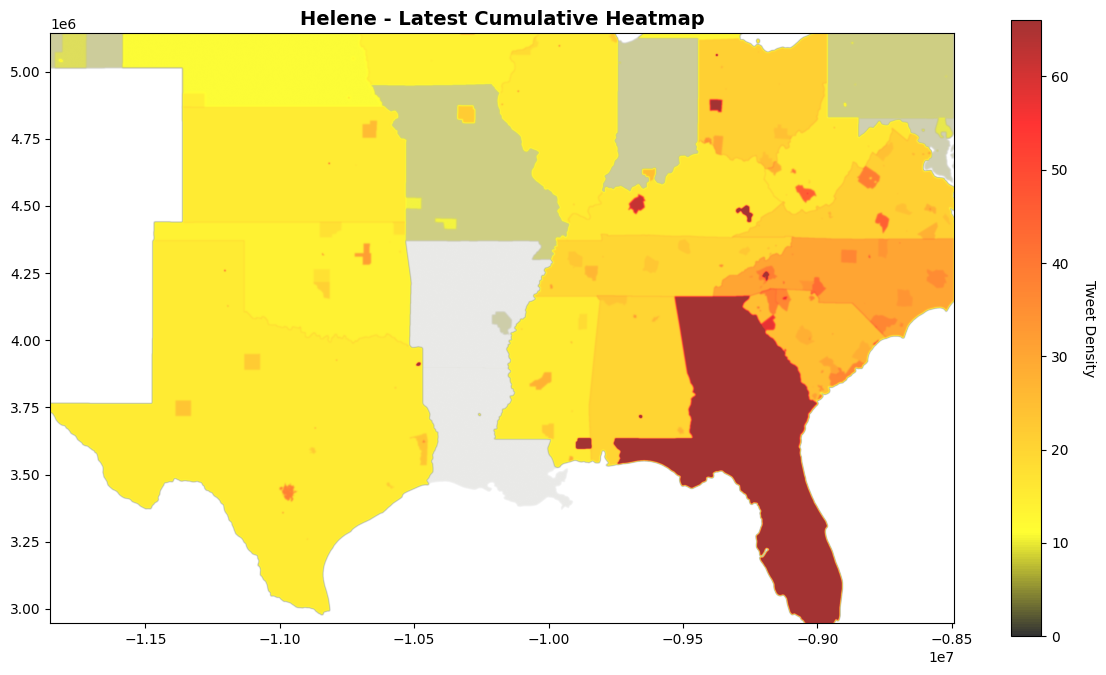

  Data range: 0.0 - 371.9
  95th percentile: 66.0
  Non-zero pixels: 5,174,234

✓ HELENE heatmap processing complete!
  Smoothed rasters: C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\helene\heatmap
  Styled rasters: C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\helene\styled

ALL HEATMAP PROCESSING COMPLETE! 🔥


In [100]:
# PLACE THIS CODE AFTER YOUR RASTER GENERATION IS COMPLETE
# =============================================================================
# HEATMAP POST-PROCESSING AND STYLING
# =============================================================================

import numpy as np
import rasterio
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from rasterio.plot import show
import glob
import os

def apply_heatmap_smoothing(input_raster_path, output_raster_path, sigma_multiplier=2.0):
    """
    Apply gaussian smoothing to create heatmap effect

    Parameters:
    - sigma_multiplier: Controls smoothing intensity (higher = more blur)
    """
    with rasterio.open(input_raster_path) as src:
        data = src.read(1).astype(np.float32)
        profile = src.profile.copy()

        # Apply gaussian filter for heatmap smoothing
        # Sigma is relative to cell size for consistent smoothing
        sigma = sigma_multiplier  # pixels
        smoothed_data = gaussian_filter(data, sigma=sigma, mode='constant', cval=0)

        # Ensure no negative values
        smoothed_data = np.maximum(smoothed_data, 0)

        # Update profile for output
        profile.update(dtype=rasterio.float32, compress='lzw')

        # Write smoothed raster
        with rasterio.open(output_raster_path, 'w', **profile) as dst:
            dst.write(smoothed_data, 1)

    print(f"  Smoothed: {os.path.basename(output_raster_path)}")

    # Return stats
    original_max = np.max(data)
    smoothed_max = np.max(smoothed_data)
    return original_max, smoothed_max

def create_heatmap_versions(hurricane_dir, hurricane_name, sigma=2.0):
    """Create smoothed heatmap versions of all rasters"""
    print(f"\nCreating heatmap versions for {hurricane_name}...")

    # Create heatmap subdirectory
    heatmap_dir = os.path.join(hurricane_dir, 'heatmap')
    os.makedirs(heatmap_dir, exist_ok=True)

    # Process all cumulative rasters (these are usually more interesting for heatmaps)
    cumulative_files = glob.glob(os.path.join(hurricane_dir, f"{hurricane_name}_cumulative_*.tif"))

    stats = []
    for tif_path in sorted(cumulative_files):
        filename = os.path.basename(tif_path)
        heatmap_filename = filename.replace('.tif', '_heatmap.tif')
        heatmap_path = os.path.join(heatmap_dir, heatmap_filename)

        orig_max, smooth_max = apply_heatmap_smoothing(tif_path, heatmap_path, sigma)
        stats.append((filename, orig_max, smooth_max))

    print(f"  Created {len(cumulative_files)} heatmap rasters in: {heatmap_dir}")

    # Print smoothing statistics
    print(f"  Smoothing statistics:")
    for filename, orig_max, smooth_max in stats[:3]:  # Show first 3
        print(f"    {filename}: {orig_max:.1f} → {smooth_max:.1f} (max value)")

    return heatmap_dir

def create_heatmap_colormap():
    """Create yellow-to-red heatmap colormap with transparent zero"""
    colors = [
        (0, 0, 0, 0),        # Transparent for 0
        (1, 1, 0, 1),        # Yellow (low values)
        (1, 0.75, 0, 1),     # Yellow-Orange
        (1, 0.5, 0, 1),      # Orange
        (1, 0.25, 0, 1),     # Orange-Red
        (1, 0, 0, 1),        # Red (high values)
        (0.55, 0, 0, 1),     # Dark Red (highest)
    ]

    cmap = mcolors.LinearSegmentedColormap.from_list('heatmap', colors, N=256)
    cmap.set_under(color=(0, 0, 0, 0))  # Ensure values <= 0 are transparent

    return cmap

def preview_heatmap(raster_path, title="Heatmap Preview"):
    """Create a preview of the heatmap with proper styling"""

    with rasterio.open(raster_path) as src:
        data = src.read(1)

        # Create figure
        fig, ax = plt.subplots(figsize=(12, 8))

        # Get custom colormap
        cmap = create_heatmap_colormap()

        # Set up visualization
        # Use 95th percentile for max to avoid outliers dominating the scale
        vmax = np.percentile(data[data > 0], 95) if np.any(data > 0) else np.max(data)
        vmin = 0

        # Display raster
        show(src, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8)

        # Styling
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_aspect('equal')

        # Add colorbar
        im = ax.images[0]
        cbar = plt.colorbar(im, ax=ax, shrink=0.8, aspect=20)
        cbar.set_label('Tweet Density', rotation=270, labelpad=20)

        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"  Data range: {np.min(data):.1f} - {np.max(data):.1f}")
        print(f"  95th percentile: {vmax:.1f}")
        print(f"  Non-zero pixels: {np.count_nonzero(data):,}")

def export_styled_geotiff(input_path, output_path, apply_colormap=True):
    """Export a styled GeoTIFF with embedded colormap for direct use in web maps"""

    with rasterio.open(input_path) as src:
        data = src.read(1)
        profile = src.profile.copy()

        if apply_colormap:
            # Convert to 8-bit for colormap application
            vmax = np.percentile(data[data > 0], 95) if np.any(data > 0) else np.max(data)
            data_normalized = np.clip((data / vmax) * 255, 0, 255).astype(np.uint8)

            # Update profile for 8-bit output
            profile.update(
                dtype=rasterio.uint8,
                count=1,
                compress='lzw'
            )

            # Write the normalized data
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(data_normalized, 1)

                # Create and write colormap
                cmap = create_heatmap_colormap()
                colormap = {}
                for i in range(256):
                    rgba = cmap(i / 255.0)
                    # Convert to 0-255 range
                    colormap[i] = tuple(int(c * 255) for c in rgba)

                dst.write_colormap(1, colormap)
        else:
            # Keep as float32
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(data, 1)

    print(f"  Exported styled raster: {os.path.basename(output_path)}")

# =============================================================================
# EXECUTE HEATMAP PROCESSING
# =============================================================================

def process_hurricane_heatmaps(hurricane_name, hurricane_dir, preview_latest=True):
    """Complete heatmap processing pipeline for a hurricane"""

    print(f"\n{'='*60}")
    print(f"HEATMAP PROCESSING: {hurricane_name.upper()}")
    print(f"{'='*60}")

    # Step 1: Create smoothed heatmap versions
    heatmap_dir = create_heatmap_versions(hurricane_dir, hurricane_name, sigma=2.5)

    # Step 2: Create web-ready styled versions
    styled_dir = os.path.join(hurricane_dir, 'styled')
    os.makedirs(styled_dir, exist_ok=True)

    heatmap_files = glob.glob(os.path.join(heatmap_dir, "*.tif"))

    for heatmap_file in sorted(heatmap_files):
        filename = os.path.basename(heatmap_file)
        styled_filename = filename.replace('_heatmap.tif', '_styled.tif')
        styled_path = os.path.join(styled_dir, styled_filename)

        export_styled_geotiff(heatmap_file, styled_path, apply_colormap=True)

    # Step 3: Preview the latest heatmap
    if preview_latest and heatmap_files:
        latest_heatmap = sorted(heatmap_files)[-1]
        preview_heatmap(latest_heatmap, f"{hurricane_name.title()} - Latest Cumulative Heatmap")

    print(f"\n✓ {hurricane_name.upper()} heatmap processing complete!")
    print(f"  Smoothed rasters: {heatmap_dir}")
    print(f"  Styled rasters: {styled_dir}")

    return heatmap_dir, styled_dir

# Run processing for your hurricanes
print("\n" + "="*60)
print("HEATMAP POST-PROCESSING")
print("="*60)

# Process both hurricanes
francine_dir = os.path.join(output_dir, 'francine')
helene_dir = os.path.join(output_dir, 'helene')

if os.path.exists(francine_dir):
    francine_heatmap_dir, francine_styled_dir = process_hurricane_heatmaps('francine', francine_dir)

if os.path.exists(helene_dir):
    helene_heatmap_dir, helene_styled_dir = process_hurricane_heatmaps('helene', helene_dir)

print("\n" + "="*60)
print("ALL HEATMAP PROCESSING COMPLETE! 🔥")


In [102]:
import arcpy
import os
from datetime import datetime


# Note this is to be inserted into the python command window
# Paths
gdb_path = r"C:\Users\colto\Documents\GitHub\Tweet_project\Tweet_project.gdb"


raster_folder = r"C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\helene\cumulative"
mosaic_name = "helene_cumulative_mosaic_v2"

raster_folder = r"C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\helene\increment"
mosaic_name = "helene_increment_mosaic_v2"

raster_folder = r"C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\francine\cumulative"
mosaic_name = "francine_cumulative_mosaic_v2"

raster_folder = r"C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\francine\increment"
mosaic_name = "francine_increment_mosaic_v2"



# Create geodatabase if it doesn't exist
if not arcpy.Exists(gdb_path):
    arcpy.CreateFileGDB_management(os.path.dirname(gdb_path), os.path.basename(gdb_path))

# Create mosaic dataset
mosaic_path = os.path.join(gdb_path, mosaic_name)
if arcpy.Exists(mosaic_path):
    arcpy.Delete_management(mosaic_path)

arcpy.CreateMosaicDataset_management(gdb_path, mosaic_name, "PROJCS['WGS_1984_Web_Mercator_Auxiliary_Sphere',GEOGCS['GCS_WGS_1984',DATUM['D_WGS_1984',SPHEROID['WGS_1984',6378137.0,298.257223563]],PRIMEM['Greenwich',0.0],UNIT['Degree',0.0174532925199433]],PROJECTION['Mercator_Auxiliary_Sphere'],PARAMETER['False_Easting',0.0],PARAMETER['False_Northing',0.0],PARAMETER['Central_Meridian',0.0],PARAMETER['Standard_Parallel_1',0.0],PARAMETER['Auxiliary_Sphere_Type',0.0],UNIT['Meter',1.0]]")

print(f"Created mosaic dataset: {mosaic_path}")

# Add rasters to mosaic
arcpy.AddRastersToMosaicDataset_management(
    mosaic_path,
    "Raster Dataset",
    raster_folder,
    filter="*.tif"
)

print("Added rasters to mosaic dataset")

# Add time field
arcpy.AddField_management(mosaic_path, "date", "DATE")

# Calculate time from filename
with arcpy.da.UpdateCursor(mosaic_path, ["Name", "date"]) as cursor:
    for row in cursor:
        filename = row[0]
        # Remove .tif extension and split
        parts = filename.replace(".tif", "").split("_")

        # Join last two parts to get full timestamp: 20240926 + 080000
        time_str = parts[-2] + parts[-1]  # Combines date and time

        # Parse: 20240926080000 -> datetime
        dt = datetime.strptime(time_str, "%Y%m%d%H%M%S")
        print(f"{filename} -> {time_str} -> {dt}")
        row[1] = dt
        cursor.updateRow(row)

print("Time field populated")

# Configure mosaic properties
arcpy.SetMosaicDatasetProperties_management(
    mosaic_path,
    start_time_field="date"
)

print("Mosaic dataset configured with time dimension")

print(f"\nMosaic dataset complete: {mosaic_path}")
print("To apply symbology in ArcGIS Pro:")
print(f"1. Add mosaic to map: {mosaic_path}")
print(f"2. Right-click layer > Symbology > Import")
print(f"3. Select: {symbology_file}")
print("4. Enable time slider to animate cumulative growth")

ModuleNotFoundError: No module named 'arcpy'

In [90]:
# import arcpy
# import os
# from datetime import datetime
#
# # Paths
#
# raster_folder = r"C:\Users\colto\Documents\GitHub\Tweet_project\rasters_output\helene\increment"
# gdb_path = r"C:\Users\colto\Documents\GitHub\Tweet_project\Tweet_project.gdb"
# mosaic_name = "helene_cumulative_mosaic_v3"
# coordinate_system = "PROJCS['WGS_1984_Web_Mercator_Auxiliary_Sphere',GEOGCS['GCS_WGS_1984',DATUM['D_WGS_1984',SPHEROID['WGS_1984',6378137.0,298.257223563]],PRIMEM['Greenwich',0.0],UNIT['Degree',0.0174532925199433]],PROJECTION['Mercator_Auxiliary_Sphere'],PARAMETER['False_Easting',0.0],PARAMETER['False_Northing',0.0],PARAMETER['Central_Meridian',0.0],PARAMETER['Standard_Parallel_1',0.0],PARAMETER['Auxiliary_Sphere_Type',0.0],UNIT['Meter',1.0]]"
# # Create geodatabase if it doesn't exist
# if not arcpy.Exists(gdb_path):
#     arcpy.CreateFileGDB_management(os.path.dirname(gdb_path), os.path.basename(gdb_path))
#
# # Create mosaic dataset
# # Create mosaic dataset with the CORRECT pixel type
# mosaic_path = os.path.join(gdb_path, mosaic_name)
# if arcpy.Exists(mosaic_path):
#     arcpy.Delete_management(mosaic_path)
#
# # --- THIS IS THE LINE TO CHANGE ---
# arcpy.CreateMosaicDataset_management(
#     in_workspace=gdb_path,
#     in_mosaicdataset_name=mosaic_name,
#     coordinate_system=coordinate_system,
#     num_bands=1, # Add this line
#     pixel_type='32_BIT_FLOAT' # Add this line
# )
# print(f"Created mosaic dataset: {mosaic_path}")
#
# # Add rasters to mosaic
# arcpy.AddRastersToMosaicDataset_management(
#     mosaic_path,
#     "Raster Dataset",
#     raster_folder,
#     filter="*.tif"
# )
#
# print("Added rasters to mosaic dataset")
#
# # Add time field
# arcpy.AddField_management(mosaic_path, "date", "DATE")
#
# # Calculate time from filename
# # Calculate time from filename
# # Calculate time from filename
# with arcpy.da.UpdateCursor(mosaic_path, ["Name", "date"]) as cursor:
#     for row in cursor:
#         filename = row[0]
#         # Remove .tif extension and split
#         parts = filename.replace(".tif", "").split("_")
#
#         # Join last two parts to get full timestamp: 20240926 + 080000
#         time_str = parts[-2] + parts[-1]  # Combines date and time
#
#         # Parse: 20240926080000 -> datetime
#         dt = datetime.strptime(time_str, "%Y%m%d%H%M%S")
#         print(f"{filename} -> {time_str} -> {dt}")
#         row[1] = dt
#         cursor.updateRow(row)
#
# print("Time field populated")
#
# # Configure mosaic properties
# arcpy.SetMosaicDatasetProperties_management(
#     mosaic_path,
#     start_time_field="date"
# )
#
# print("Mosaic dataset configured with time dimension")
# arcpy.CalculateStatistics_management(mosaic_path)
# print(f"\nMosaic dataset complete: {mosaic_path}")
# print("To apply symbology in ArcGIS Pro:")
# print(f"1. Add mosaic to map: {mosaic_path}")
# print(f"2. Right-click layer > Symbology > Import")
# print(f"3. Select: {symbology_file}")
# print("4. Enable time slider to animate cumulative growth")

ModuleNotFoundError: No module named 'arcpy'